<a href="https://colab.research.google.com/github/HopeMeNow/d2l/blob/main/classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

Тестовое задание по NLP

@ - Опционально, будет плюсом

1) Сделать классификатор интентов
  - Для обучения использовать датасет https://github.com/PolyAI-LDN/task-specific-datasets/banking_data/
  - Сделать небольшой отчет в свободной форме для оценки качества решения
    (tf-idf baseline на тесте выбивает от 0.9 f1-score -
     если не получится улучшить -
     не критично, но выше бейзлайна будет большим плюсом)
  - Цель: написать более менее адекватную архитектуру, построить читаемый отчет
  - @ Реализовать Self-adjusting Dice Loss из  https://www.aclweb.org/anthology/2020.acl-main.45.pdf
    Сравнить с Cross Entropy
  - @ Реализовать механизм семплинга батчей, чтобы компенсировать несбалансированность классов в датасете
    Сравнить с обычным семплингом

2) Обернуть классификатор в REST сервис
  - Метод POST /classify
  - На вход подается текст примера
  - В ответ возвращается строковый тег интента
  - Сервис должен быть завернут в docker контейнер

# Classification

## Importing packages and load data

In [ ]:
!pip install pytorch-pretrained-bert pytorch-nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 28.4 MB/s 
     |████████████████████████████████| 90 kB 12.1 MB/s 
     |████████████████████████████████| 132 kB 46.3 MB/s 
     |████████████████████████████████| 79 kB 11.0 MB/s 
     |████████████████████████████████| 8.8 MB 56.7 MB/s 
     |████████████████████████████████| 138 kB 45.1 MB/s 
     |████████████████████████████████| 127 kB 62.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
import seaborn as sns

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig, BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import io

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls 'drive/MyDrive/Colab Notebooks/testTinkoff'

categories.json  classifier.ipynb  test.csv  train.csv


In [ ]:
train = pd.read_csv('drive/MyDrive/Colab Notebooks/testTinkoff/train.csv')
train.head()

,text,category
0,I am still waiting on my card?,card_arrival
1,What can I do if my card still hasn't arrived ...,card_arrival
2,I have been waiting over a week. Is the card s...,card_arrival
3,Can I track my card while it is in the process...,card_arrival
4,"How do I know if I will get my card, or if it ...",card_arrival


In [ ]:
test = pd.read_csv('drive/MyDrive/Colab Notebooks/testTinkoff/test.csv')
test.head()

,text,category
0,How do I locate my card?,card_arrival
1,"I still have not received my new card, I order...",card_arrival
2,I ordered a card but it has not arrived. Help ...,card_arrival
3,Is there a way to know when my card will arrive?,card_arrival
4,My card has not arrived yet.,card_arrival


In [ ]:
with open('drive/MyDrive/Colab Notebooks/testTinkoff/categories.json') as f:
  categories = json.load(f)

len(categories)

77

## Discover data

Какие графики полезно нарисовать для задачи классификации текстов? Я придумала только распределение классов.

In [ ]:
train_cats = train.groupby('category').text.count().sort_values()
train_cats

category
contactless_not_working                              35
virtual_card_not_working                             41
card_acceptance                                      59
card_swallowed                                       61
lost_or_stolen_card                                  82
                                                   ... 
cash_withdrawal_charge                              177
wrong_amount_of_cash_received                       180
balance_not_updated_after_cheque_or_cash_deposit    181
direct_debit_payment_not_recognised                 182
card_payment_fee_charged                            187
Name: text, Length: 77, dtype: int64

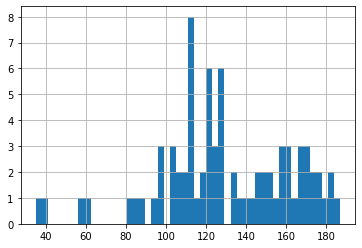

In [ ]:
train_cats.hist(bins=50)

In [ ]:
test_cats = test.groupby('category').text.count().sort_values()
test_cats

category
Refund_not_showing_up                      40
supported_cards_and_currencies             40
reverted_card_payment?                     40
request_refund                             40
receiving_money                            40
                                           ..
change_pin                                 40
cash_withdrawal_not_recognised             40
cash_withdrawal_charge                     40
declined_cash_withdrawal                   40
wrong_exchange_rate_for_cash_withdrawal    40
Name: text, Length: 77, dtype: int64

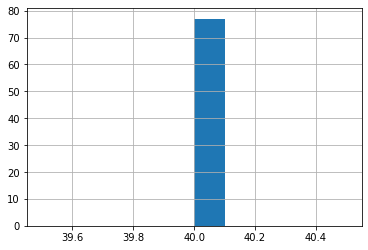

In [ ]:
test_cats.hist()

## Prepare data

В том же примере с каггл чел считает какие слова сильнее коррелируют с правильными метками. Выглядит красиво, но зачем? Как потом можно применить эту информацию?

In [ ]:
categories_codes = dict(zip(categories, range(len(categories))))

In [ ]:
train_corpus = train['text'].to_numpy()
train_corpus

array(['I am still waiting on my card?',
       "What can I do if my card still hasn't arrived after 2 weeks?",
       'I have been waiting over a week. Is the card still coming?', ...,
       'What countries are getting support?',
       'Are cards available in the EU?',
       'Which countries are represented?'], dtype=object)

In [ ]:
test_corpus = test['text'].to_numpy()
test_corpus

array(['How do I locate my card?',
       'I still have not received my new card, I ordered over a week ago.',
       'I ordered a card but it has not arrived. Help please!', ...,
       'What countries do you do business in?',
       'What are the countries you operate in.',
       'Can the card be mailed and used in Europe?'], dtype=object)

## TF-IDF

### Train data

In [ ]:
import re, string
re_tok = re.compile(f([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’]))
def tokenize(s): return re_tok.sub(r \1 , s).split()

SyntaxError: ignored

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), analyzer='word',
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1)
X_train = vectorizer.fit_transform(train_corpus)
y_train = train['category'].replace(categories_codes)

### Test data

In [ ]:
X_test = vectorizer.transform(test_corpus)
y_test = test['category'].replace(categories_codes)

### Models
#### Models comparison

Нашла на kaggle статьи, где tf-idf используется с классическими моделями. Это вообще в реальности где-то используется или больше какой-то учебный вариант, чтобы понять как работать с текстами?

In [ ]:
models = [
  LinearSVC(),
  RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
  MultinomialNB(),
  LogisticRegression(random_state=0),
]

Судя по описанию в документации, мне нужна метрика f1_samples, но она выкидывает ошибку и по факту работает только f1_weighted и я не уверена, что это то, что мне нужно.

In [ ]:
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  f1_scrs = cross_val_score(model, X_train, y_train, scoring='f1_weighted', cv=CV)
  for fold_idx, f1_scr in enumerate(f1_scrs):
    entries.append((model_name, fold_idx, f1_scr))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'f1_scr'])

In [ ]:
cv_df

,model_name,fold_idx,f1_scr
0,LinearSVC,0,0.881823
1,LinearSVC,1,0.891737
2,LinearSVC,2,0.875876
3,LinearSVC,3,0.890347
4,LinearSVC,4,0.875780
5,RandomForestClassifier,0,0.540987
6,RandomForestClassifier,1,0.531578
7,RandomForestClassifier,2,0.522960
8,RandomForestClassifier,3,0.547073
9,RandomForestClassifier,4,0.553348


Text(0.5, 1.0, 'MEAN F1 (cv = 5)')

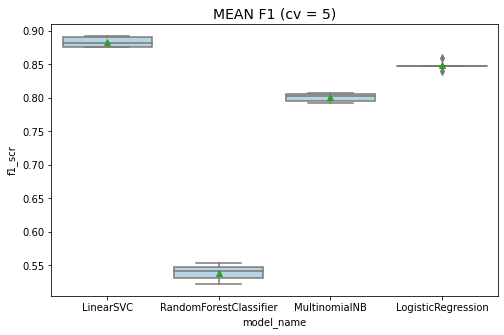

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='f1_scr',
            data=cv_df,
            color='lightblue',
            showmeans=True)
plt.title("MEAN F1 (cv = 5)", size=14)

#### Test best model

In [ ]:
final_model = LinearSVC()
final_model.fit(X_train, y_train)

predictions = final_model.predict(X_test)
f1_score(y_test.to_numpy(), predictions, average='weighted')

0.8867754070155793

## Neural network

В задании дана цель написать "более менее адекватную" архитектуру. Какая вообще архитектура является адекватной?
В документациях и ознакомительной литературе рассказывается про то, какие есть слои, но не очень понятно как их использовать, есть ли какие-то бест практисы

In [ ]:
seed = 7
np.random.seed(seed)
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

In [ ]:
def batch_generator(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y_data)[0])
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:].toarray()
        y_batch = y_data[y_data.index[index_batch]]
        counter += 1
        yield X_batch,y_batch
        if (counter > number_of_batches):
            counter=0

In [ ]:
%%time
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=100000))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit_generator(generator=batch_generator(X_train, y_train, 32),
                    epochs=5, validation_data=(X_test, y_test),
                    steps_per_epoch=X_train.shape[0]/32)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/5


InvalidArgumentError: ignored

## Bert

In [ ]:
sentences = ["[CLS] " + query + " [SEP]" for query in train_corpus]
sentences[0]

'[CLS] I am still waiting on my card? [SEP]'

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
tokenized_texts[0]

['[CLS]', 'i', 'am', 'still', 'waiting', 'on', 'my', 'card', '?', '[SEP]']

In [ ]:
tokens_ids = [tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts]
tokens_ids[0]

[101, 1045, 2572, 2145, 3403, 2006, 2026, 4003, 1029, 102]

In [ ]:
MAX_LEN = 82
input_ids = pad_sequences(tokens_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
input_ids[0]

array([ 101, 1045, 2572, 2145, 3403, 2006, 2026, 4003, 1029,  102,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0])

In [ ]:
attention_masks = []

for seq in input_ids:
  seq_mask = [float(i > 0) for i in seq]
  attention_masks.append(seq_mask)

In [ ]:
# attention_masks[0]